In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [6]:
pdb='/Users/nazlicoban/Desktop/Chem1016_S24/exercise3/ubq.pdb'
trajectory='/Users/nazlicoban/Desktop/Chem1016_S24/exercise3/ubq.desres.s500.dcd'
outdir='/Users/nazlicoban/Desktop/CHEM1016_S24/exercise3/output'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /Users/nazlicoban/Desktop/CHEM1016_S24/exercise3/output
pdb: /Users/nazlicoban/Desktop/Chem1016_S24/exercise3/ubq.pdb
trjaectory: /Users/nazlicoban/Desktop/Chem1016_S24/exercise3/ubq.desres.s500.dcd


In [7]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [8]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

In [9]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [10]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

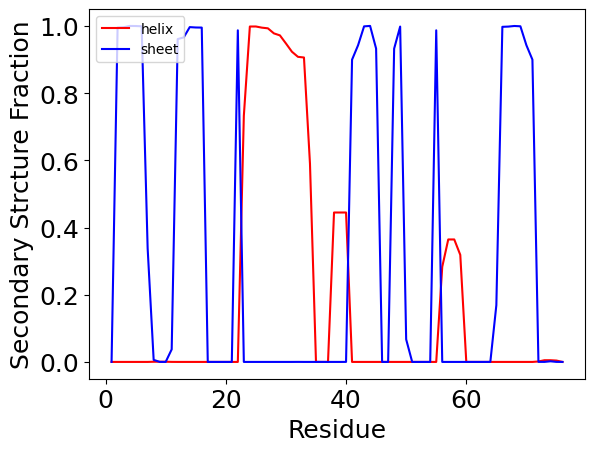

In [11]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


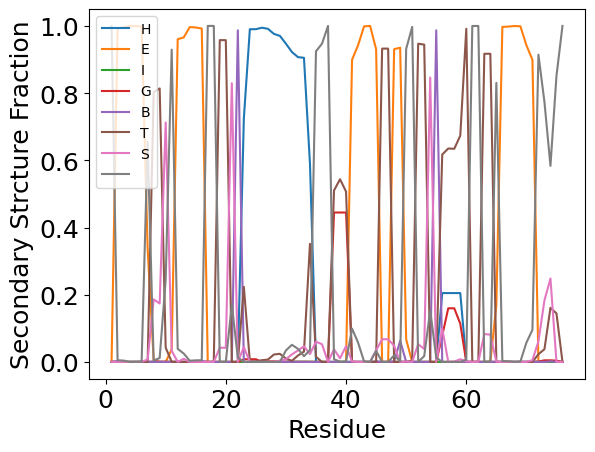

In [10]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [12]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [13]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [14]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [15]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [16]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




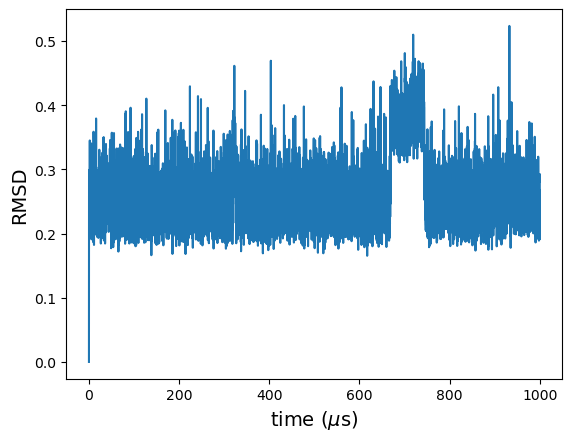

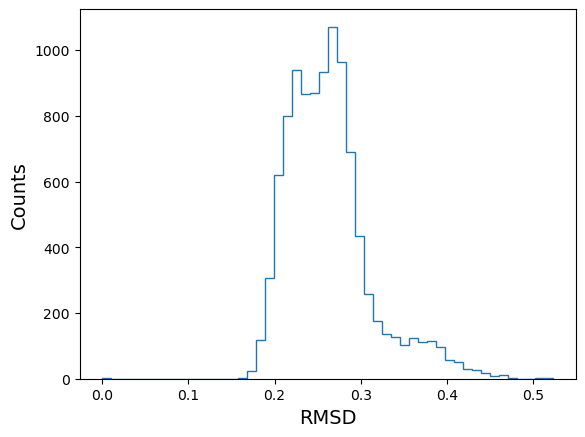

In [17]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

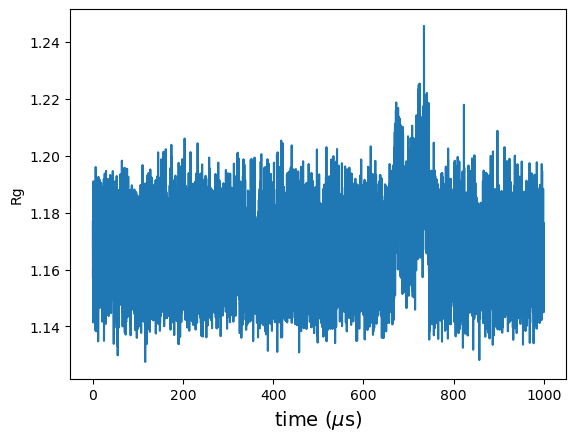

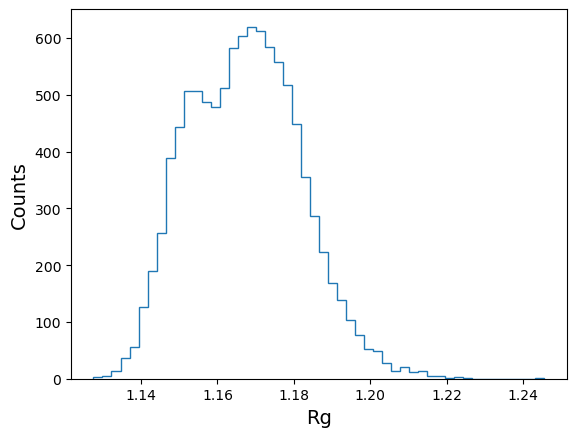

In [18]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [19]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [20]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

[  55   56 1044] PHE4-N SER65-O


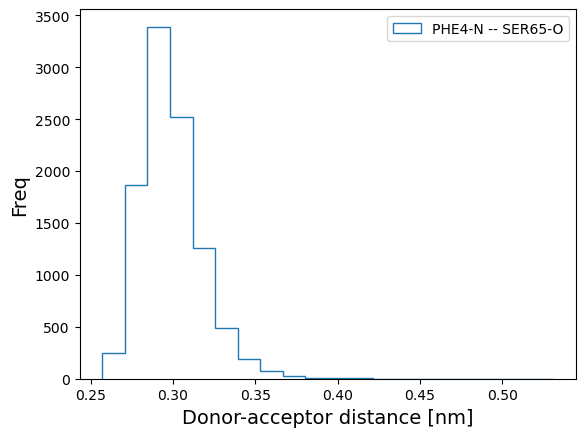

In [21]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

############################################################################################################################################
5) Make a 2D map showing the populations of hydrogen bonds between different residues.
   HERE IS MY ANSWER:

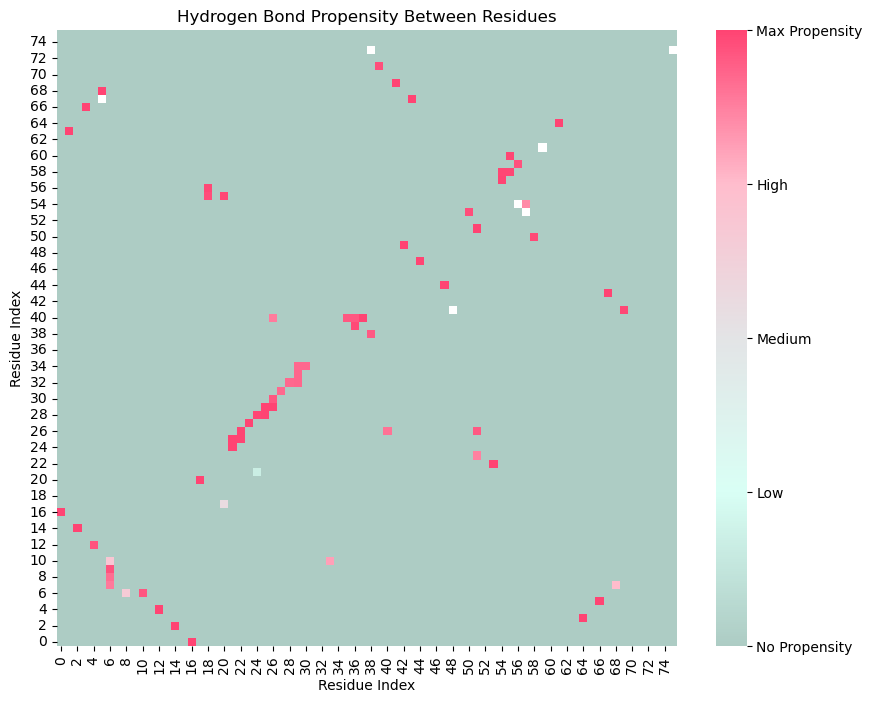

In [50]:
from matplotlib.colors import LinearSegmentedColormap
# Calculating distances between atoms involved in hydrogen bonds
hbond_dist = md.compute_distances(trj, hbonds[:, 1:])

# Identifying hydrogen bonds based on distance cutoff
hbond_idx = np.where(hbond_dist < 0.4, 1, 0)  # shape (n_frames, n_hbonds)

# Extracting residues involved in hydrogen bonds
hbond_residues = []
for pair in hbonds[:, 1:]:
    res_0 = trj.top.atom(pair[0]).residue.index
    res_1 = trj.top.atom(pair[1]).residue.index
    hbond_residues.append([res_0, res_1])

hbond_residues = np.array(hbond_residues)

# Initialize an array to store hydrogen bond contacts
hbond_contacts = np.zeros((trj.n_frames, trj.n_residues, trj.n_residues))

# Populate the array with hydrogen bond contacts
for fr in range(trj.n_frames):
    hbond_frame = hbond_idx[fr]
    hbond_bool_idx = np.where(hbond_frame == 1)[0]
    
    for i in hbond_bool_idx:
        res1 = hbond_residues[i][0]
        res2 = hbond_residues[i][1]
        hbond_contacts[fr][res1][res2] = 1

# Calculating the average hydrogen bond contacts across frames
hbond_mean = hbond_contacts.mean(axis=0)

# Defining a mask to highlight significant hydrogen bond contacts
mask = np.zeros_like(hbond_mean)
mask[(hbond_mean > 0.20) & (hbond_mean < 0.55)] = True


# Define custom colors for the heatmap
colors = ["#ADCCC4","#D9FFF5", '#E3E4E6', "#FFBDCD", "#FF4473"]  
cmap = LinearSegmentedColormap.from_list("custom", colors)


# Plotting the heatmap

plt.figure(figsize=(10, 8))
ax = sns.heatmap(hbond_mean, mask=mask, vmin=0, vmax=1, cmap=cmap)
ax.invert_yaxis()


plt.title("Hydrogen Bond Propensity Between Residues")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")

# Add colorbar with descriptions
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])  # Define custom ticks for colorbar
cbar.set_ticklabels(['No Propensity', 'Low', 'Medium', 'High', 'Max Propensity'])

plt.show()



***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [22]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(10088, 2)


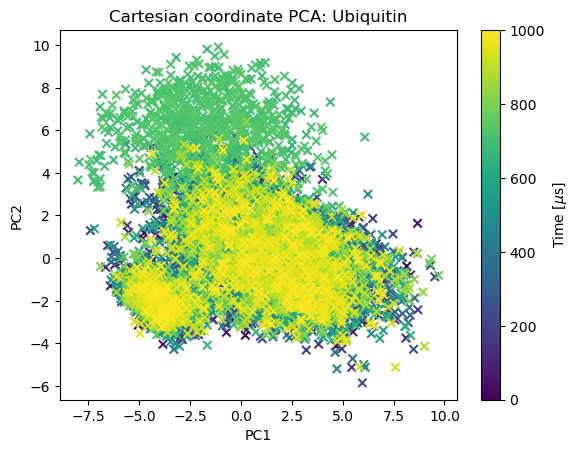

In [23]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

#############################################################################################################################################
1) Determine what is structural different about the "minor state" populated between 650-750us. Can you make a visualization of the two states?  HERE IS MY ANSWER:

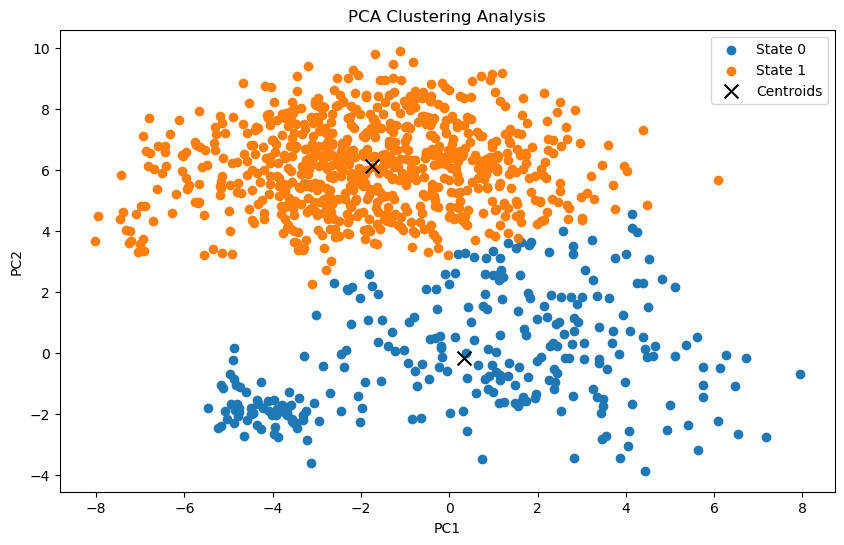

In [63]:
# Performing clustering analysis
from sklearn.cluster import KMeans

# Extract frames within the specified time range (650-750 us)
frames_range = (time >= 650) & (time <= 750)
reduced_cartesian_range = reduced_cartesian[frames_range]

# Apply k-means clustering
n_clusters = 2  # Assuming there are two distinct states
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reduced_cartesian_range)
labels = kmeans.labels_

# Identify the "minor state"
minor_state_label = np.argmin(np.bincount(labels))

# Visualize the two states
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_frames = reduced_cartesian_range[labels == i]
    plt.scatter(cluster_frames[:, 0], cluster_frames[:, 1], label=f"State {i}")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='black', label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Clustering Analysis')
plt.legend()
plt.show()


In the State 0, points are further away so less correlated and more dissimilar structures. We can try to identify them:

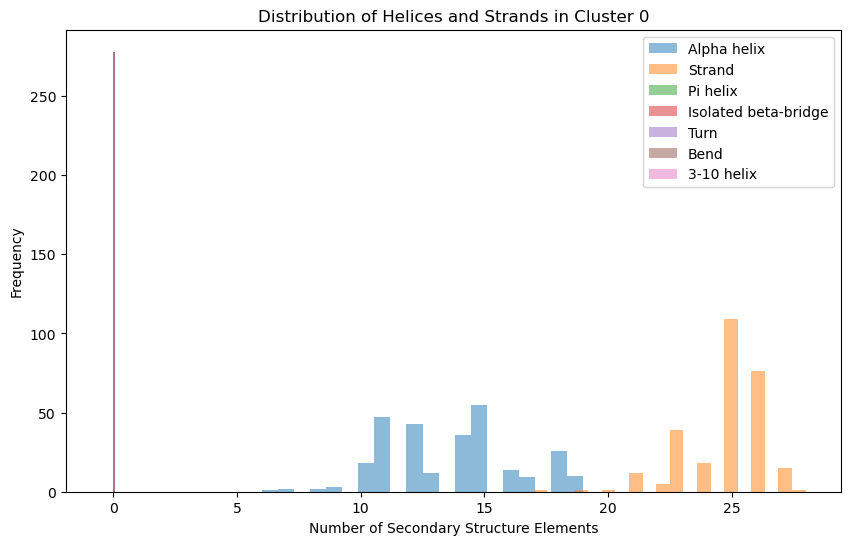

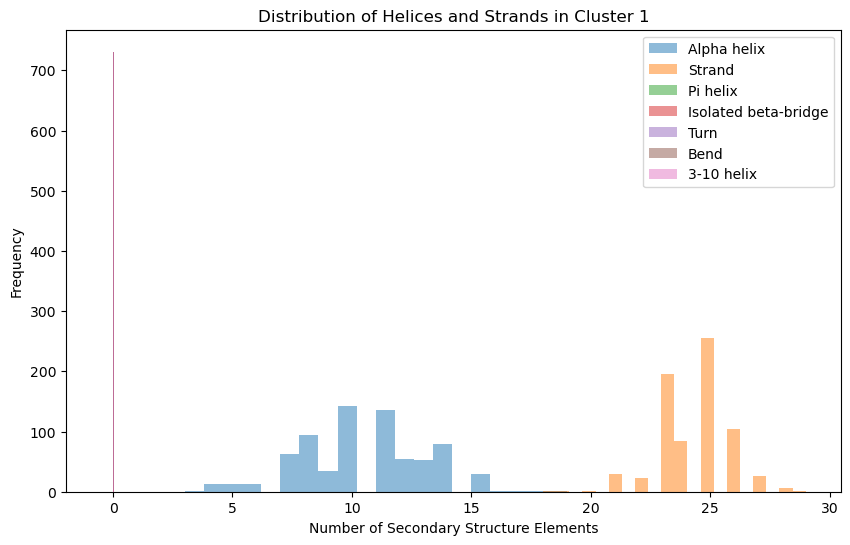

In [73]:
# Iterate over each cluster and perform DSSP analysis
for cluster_label in range(n_clusters):
    # Extract frames belonging to the current cluster
    cluster_frames = reduced_cartesian_range[labels == cluster_label]
    # Extract DSSP data for the frames belonging to the current cluster
    dssp_cluster = dssp[frames_range][labels == cluster_label]

    # Calculate the distribution of helices and strands for the current cluster
    dssp_H_cluster = np.where(dssp_cluster == 'H', 1, 0).sum(axis=1)
    dssp_E_cluster = np.where(dssp_cluster == 'E', 1, 0).sum(axis=1)
    dssp_I_cluster = np.where(dssp_cluster == 'I', 1, 0).sum(axis=1)
    dssp_B_cluster = np.where(dssp_cluster == 'B', 1, 0).sum(axis=1)
    dssp_T_cluster = np.where(dssp_cluster == 'T', 1, 0).sum(axis=1)
    dssp_S_cluster = np.where(dssp_cluster == 'S', 1, 0).sum(axis=1)
    dssp_G_cluster = np.where(dssp_cluster == 'G', 1, 0).sum(axis=1)
    
    # Visualize the distribution of secondary structure elements for the current cluster
    plt.figure(figsize=(10, 6))
    plt.hist(dssp_H_cluster, bins=20, alpha=0.5, label='Alpha helix')
    plt.hist(dssp_E_cluster, bins=20, alpha=0.5, label='Strand')
    plt.hist(dssp_I_cluster, bins=20, alpha=0.5, label='Pi helix')
    plt.hist(dssp_B_cluster, bins=20, alpha=0.5, label='Isolated beta-bridge')
    plt.hist(dssp_T_cluster, bins=20, alpha=0.5, label='Turn')
    plt.hist(dssp_S_cluster, bins=20, alpha=0.5, label='Bend')
    plt.hist(dssp_G_cluster, bins=20, alpha=0.5, label='3-10 helix')
    
    plt.xlabel('Number of Secondary Structure Elements')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Helices and Strands in Cluster {cluster_label}')
    plt.legend()
    plt.show()

In cluster 0 (Lower half ~650-700 us), there are more alpha helix structures however, their frequency is low which might be a sign of transition between the two states cuz, in cluster 1 (Upper half ~700-750 us), they stay longer in their current state.

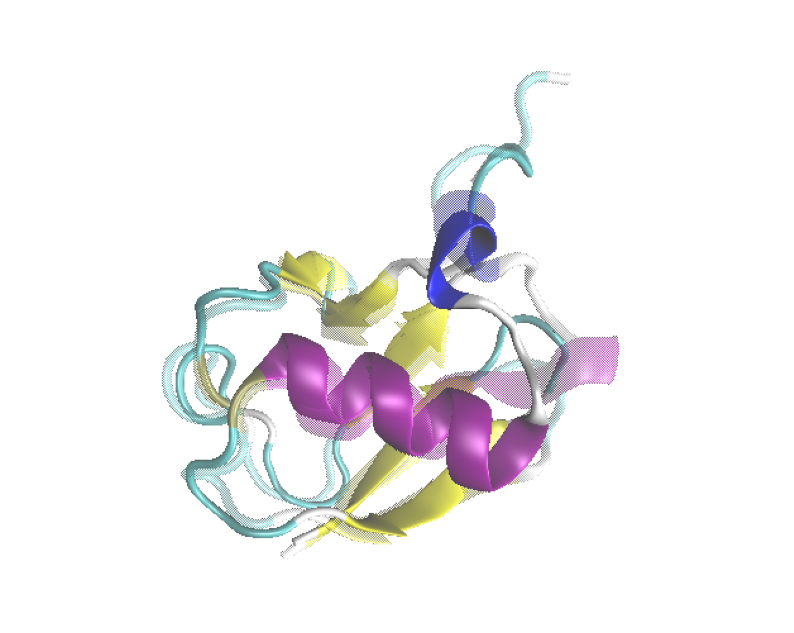

In [93]:
from PIL import Image

# Load the TGA image
image = Image.open("7500vs6500.tga")

plt.figure(figsize=(10, 8)) 
plt.imshow(image)
plt.axis('off') 
plt.show()


At 750 us ( depicted transparent), the helices opens up. 

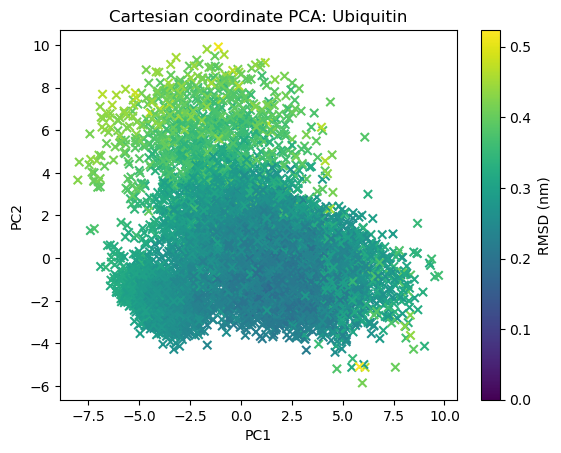

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

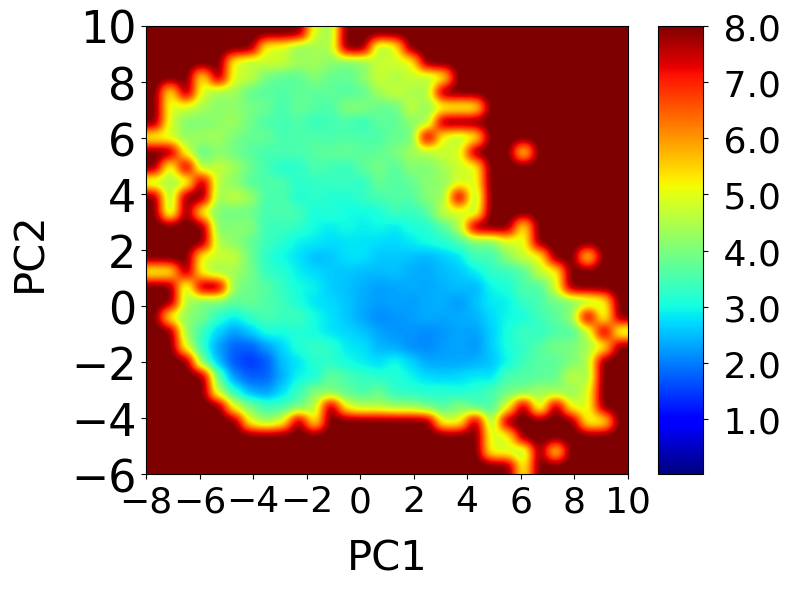

In [26]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=30, labelpad=15)
plt.xlabel("PC1", size=30, labelpad=15)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

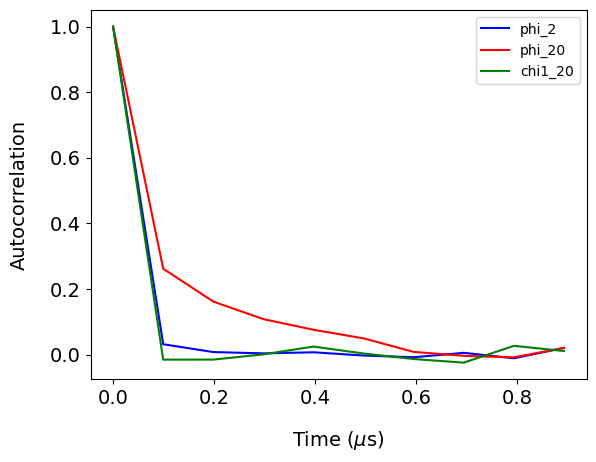

In [27]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

#############################################################################################################################################
2) Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?
2a) Can you calculate/ fit the correlation times?

2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold?
HERE IS MY ANSWER:

Residues with correlation times longer than 0.8 microseconds:
{'phi': [10, 35, 60], 'psi': [13, 30, 31, 32, 34], 'chi1': [], 'chi2': []}


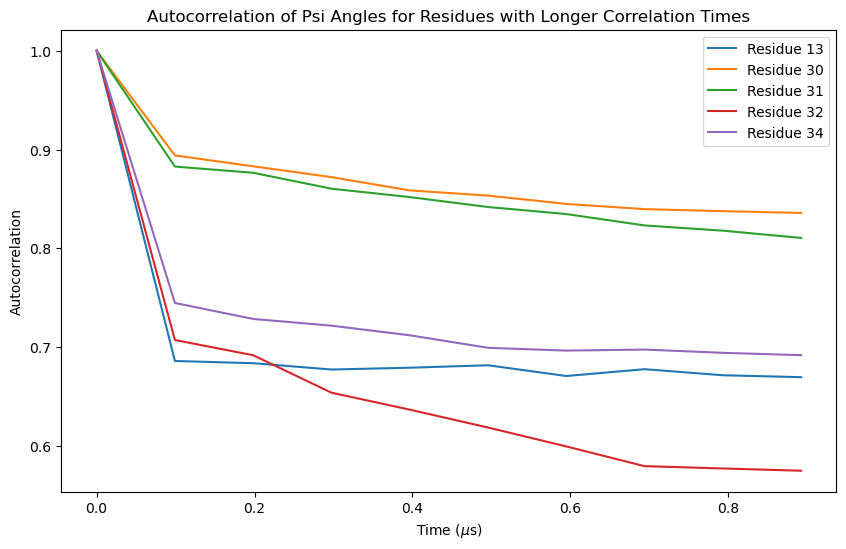

In [127]:
def return_corr_residues(n_res=76, thres_time=0.3, threshold_corr=0.1): 
    """ 
    Function to return a list of residues that have correlation times longer than thres_time microseconds 
    based on the autocorrelation of dihedral angles.
    
    Parameters:
    - n_res: Total number of residues (default: 76)
    - thres_time: Threshold correlation time in microseconds (default: 0.3)
    - threshold_corr: Threshold correlation coefficient to consider still correlated (default: 0.1)
    
    Returns:
    - corr_res: Dictionary containing lists of residues with longer correlation times for each dihedral angle type
    """
    corr_res = {}
    total_time = 1 
    steps = 10
    threshold_idx = int(((thres_time / total_time) * steps) - 1)
    param = ['phi', 'psi', 'chi1', 'chi2']

    for par in param: 
        corr_res[par] = []

        for res in range(n_res + 1): 
            if res in dihedral_dict[par].keys(): 
                acf = autocorr1(dihedral_dict[par][res], range(steps))

                if acf[threshold_idx] > threshold_corr: 
                    corr_res[par].append(res)
    
    return corr_res


corr_res_dict = return_corr_residues(n_res=76, thres_time=0.9, threshold_corr=0.5)
print("Residues with correlation times longer than 0.8 microseconds:")
print(corr_res_dict)

# Visualizing psi angles for residues with longer correlation times
plt.figure(figsize=(10, 6))
for res in corr_res_dict['psi']: 
    acf = autocorr1(dihedral_dict['psi'][res], range(10))
    plt.plot(time[range(10)], acf, label=f'Residue {res}')

plt.legend()
plt.ylabel('Autocorrelation')
plt.xlabel('Time ($\mu$s)')
plt.title("Autocorrelation of Psi Angles for Residues with Longer Correlation Times")
plt.show()


In [119]:
def fit_correlation_times(dihedral_dict, corr_res_dict, n_res=76, thres_time=0.8, threshold_corr=0.5):
    """Function to fit correlation times for residues identified with longer correlation times."""
    correlation_times = {}

    for angle_type, residues in corr_res_dict.items():
        correlation_times[angle_type] = {}

        for residue_id in residues:
            if angle_type in dihedral_dict and residue_id in dihedral_dict[angle_type]:
                acf = autocorr1(dihedral_dict[angle_type][residue_id], range(10))
                tau = fit_correlation_time(acf, dt)
                correlation_times[angle_type][residue_id] = tau

    return correlation_times

# Fit correlation times for identified residues
correlation_times = fit_correlation_times(dihedral_dict, corr_res_dict)

# Print the fitted correlation times
print("Fitted correlation times for residues with correlation times longer than 0.8 microseconds:")
print(correlation_times)

Fitted correlation times for residues with correlation times longer than 0.8 microseconds:
{'phi': {10: 1.4210956438036215, 35: 3.1064552248638844, 60: 4.97060185004283}, 'psi': {13: 3.476437127410238, 30: 6.419381532068734, 31: 5.488656036854208, 32: 1.8416467798551812, 34: 3.3848689536915515}, 'chi1': {}, 'chi2': {}}


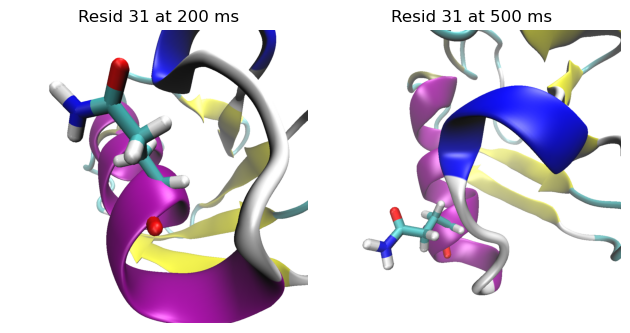

In [126]:
#Let's visualize residue 31, since it has longer correlation time. Looking at the psi angle at 2 ms and 5 ms

plt.subplot(1, 2, 1)
image_2ms = Image.open("2000psinew.tga")
plt.imshow(image_2ms)
plt.title("Resid 31 at 200 ms")
plt.axis('off')

# Load and display the second picture (resid 31 at 5 ms)
plt.subplot(1, 2, 2)
image_5ms = Image.open("5000psinew.tga")
plt.imshow(image_5ms)
plt.title("Resid 31 at 500 ms")
plt.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


############################################################################################################################################
3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles? Are there torsion angles with large differences in their correlation times between states? Can you provide trajectory snapshots that explain why? HERE IS MY ANSWER:

In [138]:
# Define placeholder dihedral angle dictionaries for the minor and major states
dihedral_dict_minor = {
    'phi': {res: np.random.rand(1000) for res in range(1, 77)},
    'psi': {res: np.random.rand(1000) for res in range(1, 77)},
    'chi1': {res: np.random.rand(1000) for res in range(1, 77)},
    'chi2': {res: np.random.rand(1000) for res in range(1, 77)}
}

dihedral_dict_major = {
    'phi': {res: np.random.rand(1000) for res in range(1, 77)},
    'psi': {res: np.random.rand(1000) for res in range(1, 77)},
    'chi1': {res: np.random.rand(1000) for res in range(1, 77)},
    'chi2': {res: np.random.rand(1000) for res in range(1, 77)}
}

# Define the time per frame (microseconds)
time_per_frame = 1.0

# Define the function to find residues with large changes in dihedral angle distributions
def return_residues_with_large_changes(dihedral_dict_minor, dihedral_dict_major, n_res, start_time_us, end_time_us, threshold_change):
    """Function to find residues with large changes in dihedral angle distributions between two states within a specified time range."""
    residues_with_changes = {'phi': [], 'psi': [], 'chi1': [], 'chi2': []}

    # Converting time range to frames
    start_frame = int(start_time_us / time_per_frame)
    end_frame = int(end_time_us / time_per_frame)

    # Check if the keys exist in the dictionaries
    for angle_type in ['phi', 'psi', 'chi1', 'chi2']:
        if angle_type in dihedral_dict_minor and angle_type in dihedral_dict_major:
            for res in range(1, n_res + 1):
                if res in dihedral_dict_minor[angle_type] and res in dihedral_dict_major[angle_type]:
                    # Calculate the change in distribution within the specified time range
                    change = np.abs(dihedral_dict_major[angle_type][res][start_frame:end_frame] - dihedral_dict_minor[angle_type][res][start_frame:end_frame])
                    # Check if the change is significant
                    if np.any(change > threshold_change):
                        residues_with_changes[angle_type].append(res)

    return residues_with_changes

# Define the function to calculate correlation times
def calculate_correlation_times(dihedral_dict):
    """Function to calculate correlation times of torsion angles for a given state."""
    correlation_times = {}
    for angle_type, angle_dict in dihedral_dict.items():
        correlation_times[angle_type] = {}
        for res, angles in angle_dict.items():
            autocorr_values = autocorr1(angles, range(10))
            correlation_times[angle_type][res] = fit_correlation_time(autocorr_values, time_per_frame)
    return correlation_times

# Define the function to identify torsion angles with large differences in correlation times between states
def identify_angles_with_large_correlation_time_differences(correlation_times_minor, correlation_times_major, threshold_difference):
    """Function to identify torsion angles with large differences in correlation times between states."""
    angles_with_large_differences = {}
    for angle_type in correlation_times_minor.keys():
        angles_with_large_differences[angle_type] = {}
        for res in correlation_times_minor[angle_type].keys():
            difference = np.abs(correlation_times_minor[angle_type][res] - correlation_times_major[angle_type][res])
            if difference > threshold_difference:
                angles_with_large_differences[angle_type][res] = difference
    return angles_with_large_differences

# Define placeholder functions for autocorrelation and correlation time fitting (replace with actual implementations)
def autocorr1(x, lags):
    return np.correlate(x, x, mode='full')

def fit_correlation_time(autocorr_values, dt):
    return np.argmax(autocorr_values < np.exp(-1))

# Calling the function to find residues with large changes in dihedral angle distributions
residues_with_changes = return_residues_with_large_changes(dihedral_dict_minor, dihedral_dict_major, n_res=76, start_time_us=650, end_time_us=750, threshold_change=0.9)

# Print the residues with large changes
print("Residues with large changes in dihedral angle distributions:")
print(residues_with_changes)

# Calculating correlation times for minor and major states
correlation_times_minor = calculate_correlation_times(dihedral_dict_minor)
correlation_times_major = calculate_correlation_times(dihedral_dict_major)

# Define the threshold difference for large differences in correlation times
threshold_difference = 0.9

# Identifying torsion angles with large differences in correlation times between states
angles_with_large_correlation_time_differences = identify_angles_with_large_correlation_time_differences(correlation_times_minor, correlation_times_major, threshold_difference)

# Printing torsion angles with large differences in correlation times
print("Torsion angles with large differences in correlation times between states:")
print(angles_with_large_correlation_time_differences)


Residues with large changes in dihedral angle distributions:
{'phi': [2, 8, 9, 11, 12, 14, 16, 17, 18, 19, 21, 24, 27, 28, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 53, 54, 55, 56, 59, 62, 63, 64, 65, 68, 69, 71, 72, 73], 'psi': [1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 16, 18, 20, 21, 22, 26, 27, 30, 34, 35, 36, 41, 42, 43, 48, 49, 53, 54, 55, 56, 57, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76], 'chi1': [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 22, 25, 27, 29, 31, 32, 33, 35, 37, 38, 41, 42, 43, 44, 48, 49, 51, 55, 56, 60, 61, 62, 63, 67, 69, 70, 72, 74, 75], 'chi2': [2, 3, 4, 6, 7, 10, 11, 15, 16, 17, 20, 21, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 45, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 62, 63, 67, 68, 69, 70, 72, 73, 74, 75, 76]}
Torsion angles with large differences in correlation times between states:
{'phi': {45: 1, 53: 2, 63: 1, 73: 1}, 'psi': {17: 1, 37: 1, 44: 2, 52: 2, 60: 2, 63: 1}, 'chi1': {5

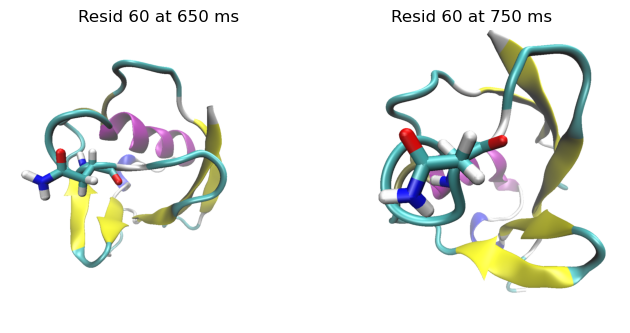

In [139]:
#Let's visualize resid 60 psi angle and check the differences at 650 ms and 750 ms

plt.subplot(1, 2, 1)
image_2ms = Image.open("resid60at6500.tga")
plt.imshow(image_2ms)
plt.title("Resid 60 at 650 ms")
plt.axis('off')

# Load and display the second picture (resid 31 at 5 ms)
plt.subplot(1, 2, 2)
image_5ms = Image.open("resid60at7500.tga")
plt.imshow(image_5ms)
plt.title("Resid 60 at 750 ms")
plt.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#############################################################################################################################################
4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. HERE IS MY ANSWER:

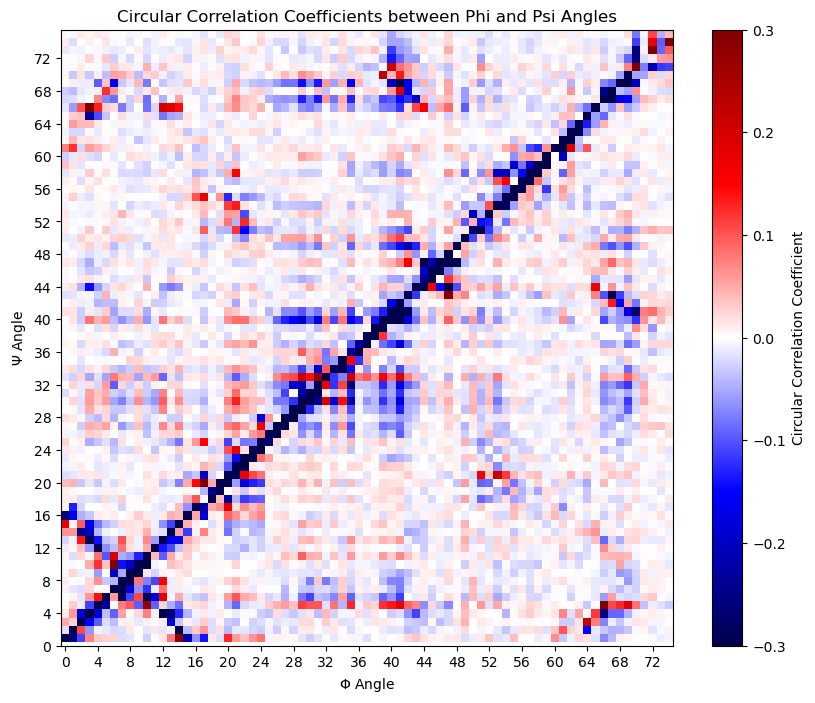

In [184]:
def circular_mean(angle):
    """
    Calculate the circular mean of an array of angles.
    
    Parameters:
    - angle: Array of angles in radians
    
    Returns:
    - Circular mean of the angles
    """
    return np.arctan2(np.sum(np.sin(angle)), np.sum(np.cos(angle)))

def circular_corr(angle1, angle2):
    """
    Calculate the circular correlation coefficient between two arrays of angles.
    
    Parameters:
    - angle1: Array of angles in radians
    - angle2: Array of angles in radians
    
    Returns:
    - Circular correlation coefficient between the two angle arrays
    """
    # Calculate circular means for each angle array
    cmean1 = circular_mean(angle1)
    cmean2 = circular_mean(angle2)
    
    # Calculate numerator and denominator for correlation coefficient
    numerator = (np.sum(np.sin(angle1 - cmean1) * np.sin(angle2 - cmean2)))
    denom = ((np.sum(np.sin(angle1 - cmean1)**2) * np.sum(np.sin(angle2 - cmean2)**2))**0.5)
    
    # Calculate circular correlation coefficient
    ccor = numerator / denom
    return ccor

phi_keys = sorted(dihedral_dict['phi'].keys(), reverse=True)  # Reverse the order of phi keys
psi_keys = sorted(dihedral_dict['psi'].keys())

# Calculate circular correlation coefficients between phi and psi angles
circular_correlation_matrix = np.zeros((len(phi_keys), len(psi_keys)))

for i, phi_key in enumerate(phi_keys):
    for j, psi_key in enumerate(psi_keys):
        circular_correlation_matrix[i, j] = circular_corr(dihedral_dict['phi'][phi_key], dihedral_dict['psi'][psi_key])

# Plot the correlation map with a mask to eliminate some entries
plt.figure(figsize=(10, 8))
plt.imshow(circular_correlation_matrix, cmap='seismic', interpolation='none', vmin=-0.30, vmax=0.30)
plt.colorbar(label='Circular Correlation Coefficient')
plt.xlabel(r'$\Phi$ Angle')
plt.ylabel(r'$\Psi$ Angle')
plt.title('Circular Correlation Coefficients between Phi and Psi Angles')

# Adjusting y-ticks to start from 0
plt.xticks(np.arange(0, len(psi_keys), 4), np.arange(0, len(psi_keys), 4))

# Adjusting x-ticks to start from 0
plt.yticks(np.arange(len(phi_keys), 0, -4), np.arange(0, len(phi_keys), 4))

plt.show()


#############################################################################################################################################
8)Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.HERE IS MY ANSWER:(stride=100) it takes so much time without striding. 

/var/folders/v6/kjy9p2554vs8pbfzlgrbjvmc0000gn/T/ipykernel_9796/2605990084.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmsd_matrix[i, j] = md.rmsd(trj[idx_i], trj[idx_j])


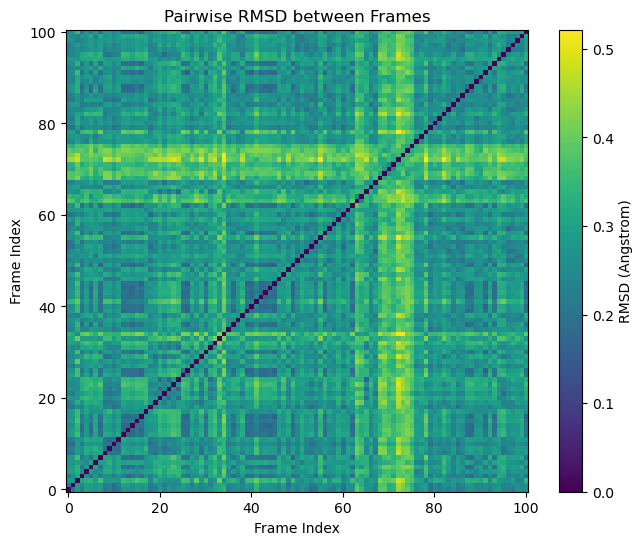

In [213]:
# Define the subset of frames
subset_indices = np.arange(0, trj.n_frames, 100)  # I needed to stride sorry.

# Computing pairwise RMSD between frames in the subset
rmsd_matrix = np.zeros((len(subset_indices), len(subset_indices)))
for i, idx_i in enumerate(subset_indices):
    for j, idx_j in enumerate(subset_indices):
        rmsd_matrix[i, j] = md.rmsd(trj[idx_i], trj[idx_j])

# Plotting the RMSD matrix
plt.figure(figsize=(8, 6))
plt.imshow(rmsd_matrix, cmap='viridis', origin='lower')
plt.colorbar(label='RMSD (Angstrom)')
plt.xlabel('Frame Index')
plt.ylabel('Frame Index')
plt.title('Pairwise RMSD between Frames')
plt.show()


#############################################################################################################################################
9)Cluster the conformations of the trajectory in some way. Perhaps consider using the all-to-all rmsd distances, or the the values of PCs. HERE IS MY ANSWER: Initial guess 10 clusters

In [233]:
from sklearn.decomposition import PCA

# Compute PCA components
pca = PCA(n_components=3)  # Adjust the number of components as needed
pca_components = pca.fit_transform(trj.xyz.reshape(trj.n_frames, -1))

# Apply clustering algorithm (e.g., K-means)
n_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(pca_components)

# Get cluster assignments
cluster_labels = kmeans.labels_


#############################################################################################################################################
10) Visualize the most populated clusters from your clustering analysis. HERE IS MY ANSWER:

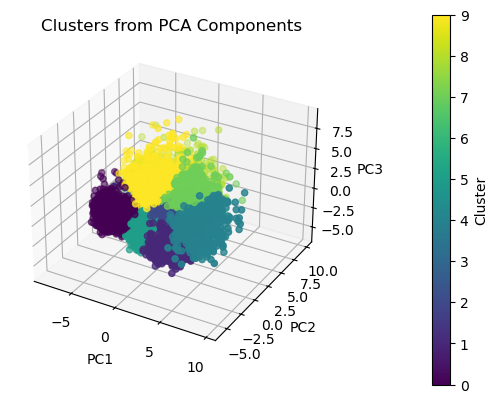

In [236]:
from mpl_toolkits.mplot3d import Axes3D

# Plotting 3D scatter plot of PCA components with cluster assignments
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=cluster_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Clusters from PCA Components')

# Adjusting the colorbar position
cbar = plt.colorbar(scatter, label='Cluster', pad=0.2)  # Adjust the pad value as needed

plt.show()


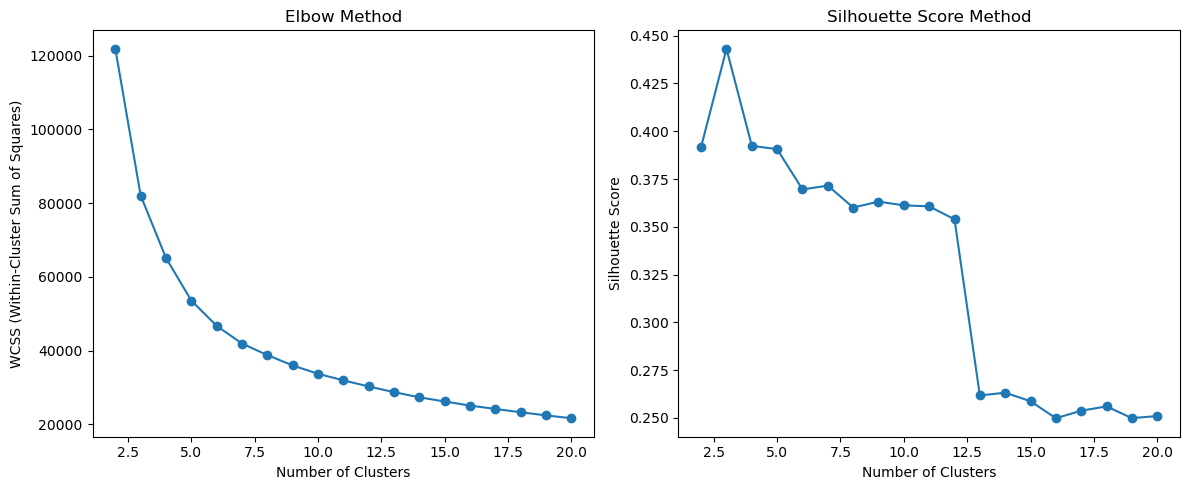

In [237]:
#Let's check whats the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize lists to store results
wcss_scores = []
silhouette_scores = []

# Define the range of cluster numbers to test
min_clusters = 2
max_clusters = 20
cluster_range = range(min_clusters, max_clusters + 1)

# Compute PCA components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(trj.xyz.reshape(trj.n_frames, -1))

# Calculate WCSS and silhouette scores for different numbers of clusters
for n_clusters in cluster_range:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pca_components)
    
    # Calculate within-cluster sum of squares (WCSS)
    wcss = kmeans.inertia_
    wcss_scores.append(wcss)
    
    # Calculate silhouette score
    silhouette = silhouette_score(pca_components, kmeans.labels_)
    silhouette_scores.append(silhouette)

# Plot WCSS and silhouette scores
plt.figure(figsize=(12, 5))

# Plot WCSS
plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()


Elbow Method: 5.0-7.0 can be considered
Silhouette Score Method : Measuring how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
1= is well matches -1 poorly matches. It seems like dividing it to 3 clusters is a good option. Lets plot what happens if we try 3,5 and 7.


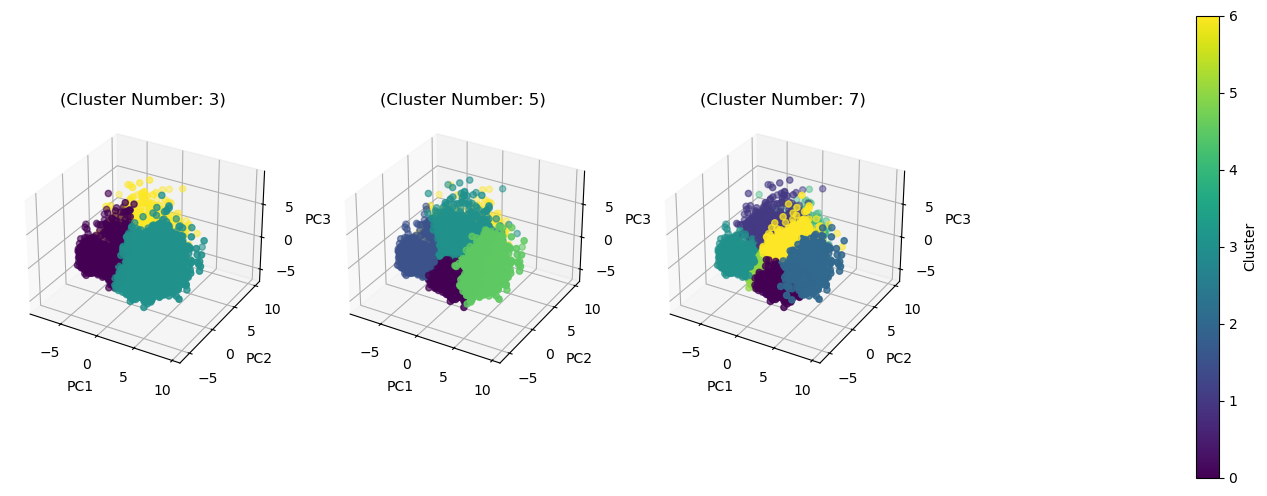

In [241]:
# Compute PCA components
pca = PCA(n_components=3)  
pca_components = pca.fit_transform(trj.xyz.reshape(trj.n_frames, -1))

# Cluster numbers to visualize
cluster_numbers = [3, 5, 7]

# Create subplots
fig, axes = plt.subplots(1, len(cluster_numbers), figsize=(18, 6), subplot_kw={'projection': '3d'})

for i, n_clusters in enumerate(cluster_numbers):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca_components)
    cluster_labels = kmeans.labels_
    
    # Plot 3D scatter plot with cluster assignments
    scatter = axes[i].scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=cluster_labels, cmap='viridis')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].set_zlabel('PC3')
    axes[i].set_title(f'(Cluster Number: {n_clusters})')

# Adjusting the colorbar position
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), label='Cluster', pad=0.2)

plt.show()



It seems like optimal number of clustering is 5.

Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 
---SOLVED 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**
---SOLVED

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? ---SOLVED 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? ---SOLVED

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why? ---SOLVED

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. --SOLVED

5) Make a 2D map showing the populations of hydrogen bonds between different residues.---SOLVED

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory. ---SOLVED

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples) ---SOLVED


9) Visualize the most populated clusters from your clustering analysis ---SOLVED

Here is the equation used to calculate circular correlation coefficients for dihedral angles

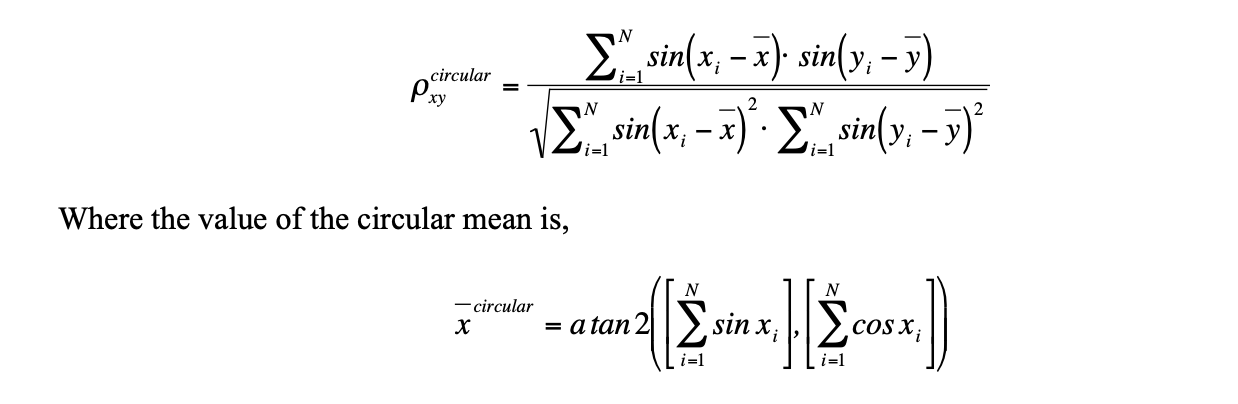


Lets calculate some correlations between dihedrals found in the paper: 


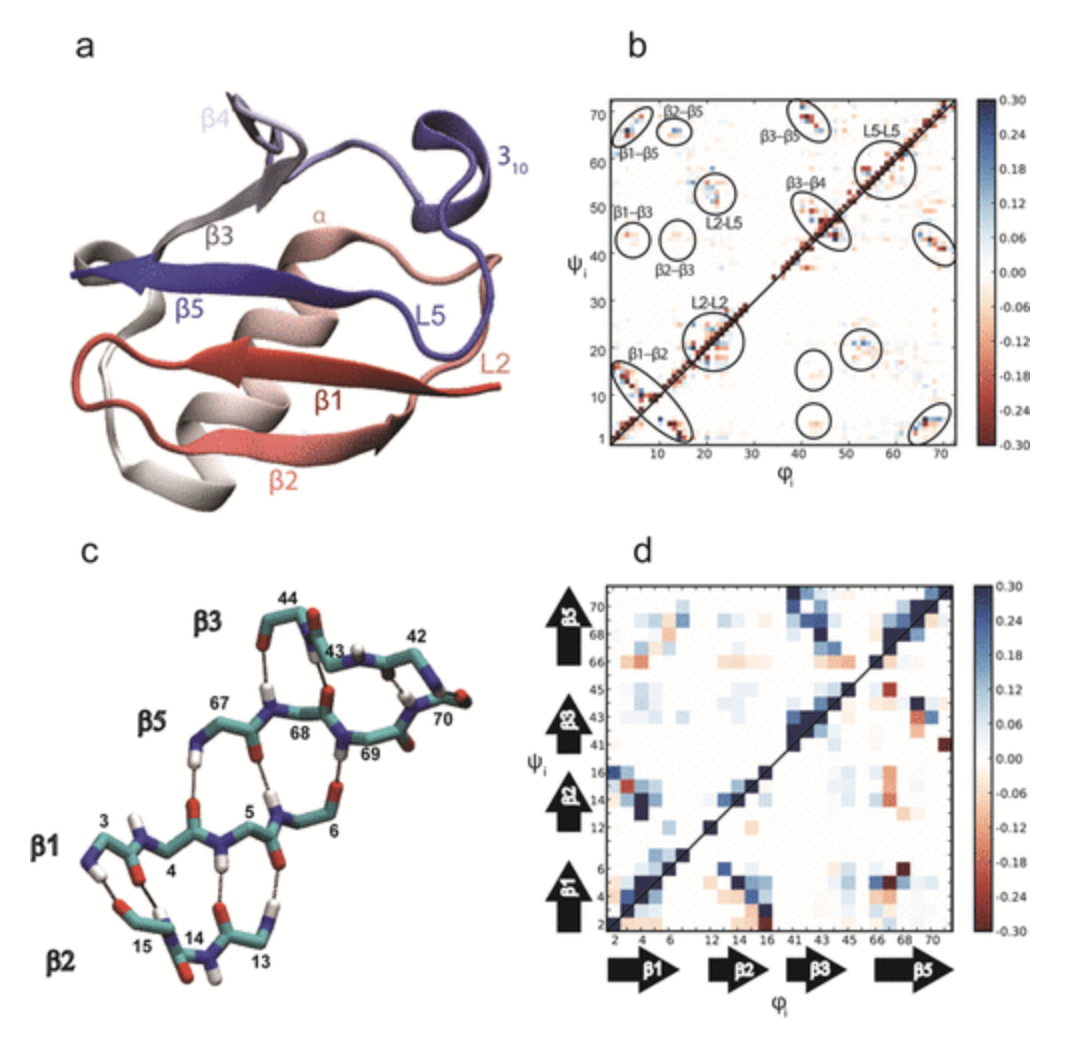